In [ ]:
%pip install requests pandas matplotlib python-dateutil

In [ ]:
repo_url = "https://github.com/SEPCheesecakeFactory/SEP3"
GITHUB_TOKEN = None  # e.g., "ghp_..."  (fine-grained: Repo: Contents(Read), Metadata(Read), Pull requests(Read))

import re, time, requests, pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt

In [ ]:
# --- helpers ---
def parse_repo(url: str):
    m = re.match(r"^https?://(?:www\.)?github\.com/([^/]+)/([^/]+?)(?:\.git)?(?:/|$)", url.strip(), re.I)
    if not m: 
        raise ValueError("Bad GitHub URL.")
    return m.group(1), m.group(2).split('/')[0]

def mk_session(token: str|None):
    s = requests.Session()
    s.headers.update({"Accept":"application/vnd.github+json","User-Agent":"nb-repo-stats"})
    if token: s.headers["Authorization"] = f"Bearer {token}"
    return s

def get_json(sess, url, params=None, ok_202_poll=False, tries=18, sleep_s=1.5):
    """GET JSON with optional 202 polling for /stats endpoints."""
    params = params or {}
    for attempt in range(tries):
        r = sess.get(url, params=params)
        # basic rate-limit/debug info
        rl = (r.headers.get("X-RateLimit-Remaining"), r.headers.get("X-RateLimit-Limit"))
        if r.status_code == 202 and ok_202_poll:
            if attempt == 0:
                print(f"warm-up 202 from {url} — polling…   (rate {rl[0]}/{rl[1]})")
            time.sleep(sleep_s); continue
        if r.status_code == 403 and "rate limit" in r.text.lower():
            reset = r.headers.get("X-RateLimit-Reset")
            wait = max(0, int(reset) - int(time.time())) + 1 if reset else 60
            print(f"rate-limited; sleeping {wait}s…")
            time.sleep(wait); continue
        if r.status_code == 404:
            raise RuntimeError("404 Not Found — private repo? wrong URL? insufficient scopes?")
        r.raise_for_status()
        try:
            return r.json()
        except Exception as e:
            raise RuntimeError(f"Non-JSON response from {url}: {e}")
    # exhausted polling
    raise TimeoutError(f"Stats not ready after {tries} polls: {url}")

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from matplotlib.dates import AutoDateLocator, DateFormatter

def plot_commits_configurable(df, repo_full_name, date_from=None, date_to=None,
                              freq="W", chart="bar", rolling=0, show_values=False, chartfigsize=(12,8)):
    """
    df: DataFrame with columns ["date", "commits"] where 'date' is datetime.date
    freq: "D" | "W" | "M"  (resample & sum)
    chart: "bar" | "line"
    rolling: window size for moving average on the resampled series (0 disables)
    """
    if df.empty:
        print("No commit data.")
        return

    # Normalize to pandas datetime index
    s = df.copy()
    s["date"] = pd.to_datetime(s["date"])
    s = s.set_index("date").sort_index()

    # Date window
    if date_from:
        s = s.loc[pd.to_datetime(date_from):]
    if date_to:
        s = s.loc[:pd.to_datetime(date_to)]

    if s.empty:
        print("No data in the selected date window.")
        return

    # Resample + sum
    y = s["commits"].resample(freq).sum()

    # Optional rolling average (post-resample)
    y_smooth = y.rolling(rolling, min_periods=max(1, rolling//2)).mean() if rolling and rolling > 0 else None

    # Prepare figure
    plt.figure(figsize=chartfigsize)

    if chart == "bar":
        ax = y.plot(kind="bar", width=0.9)
        ax.set_xlabel("Period")
    else:
        ax = y.plot(kind="line")
        ax.set_xlabel("Date")

    ax.set_title(f"Commits — {repo_full_name}  [{y.index.min().date()} → {y.index.max().date()}]  (freq={freq})")
    ax.set_ylabel("Commits")
    ax.grid(True, which="major", axis="y", alpha=0.35)

    # Date axis niceties for line charts
    if chart == "line":
        locator = AutoDateLocator()
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(ConciseDateFormatter(locator))

    # Optional rolling avg overlay (line)
    if y_smooth is not None:
        y_smooth.plot(ax=ax, linewidth=2)

    # Optional value labels
    if show_values:
        if chart == "bar":
            for p in ax.patches:
                v = int(p.get_height())
                if v:
                    ax.annotate(f"{v}", (p.get_x() + p.get_width()/2, p.get_height()),
                                ha="center", va="bottom", fontsize=8, rotation=0, xytext=(0, 2), textcoords="offset points")
        else:
            for x, v in zip(y.index, y.values):
                if v:
                    ax.annotate(f"{int(v)}", (x, v), ha="center", va="bottom", fontsize=8, xytext=(0, 3), textcoords="offset points")

    total = int(y.sum())
    ax.text(0.01, 0.95, f"Total in window: {total}", transform=ax.transAxes, ha="left", va="top")

    plt.tight_layout()
    plt.show()

# --- Compute total in selected window (matches the plot) ---
def commit_total_in_window(df, date_from=None, date_to=None):
    if df.empty:
        return 0
    s = df.copy()
    s["date"] = pd.to_datetime(s["date"])
    if date_from:
        s = s[s["date"] >= pd.to_datetime(date_from)]
    if date_to:
        s = s[s["date"] <= pd.to_datetime(date_to)]
    return int(s["commits"].sum()) if not s.empty else 0

In [16]:

# --- main ---
owner, repo = parse_repo(repo_url)
sess = mk_session(GITHUB_TOKEN)

# 1) Repo metadata (works for public; needs token for private)
repo_api = f"https://api.github.com/repos/{owner}/{repo}"
try:
    repo_info = get_json(sess, repo_api)
except Exception as e:
    print("Repo fetch error:", e)
    repo_info = {"full_name": f"{owner}/{repo}", "stargazers_count": 0, "forks_count": 0, "open_issues_count": 0}

In [17]:

# 2) Commit activity (52 weeks) with 202 polling
weekly_api = f"https://api.github.com/repos/{owner}/{repo}/stats/commit_activity"
weekly = []
try:
    weekly = get_json(sess, weekly_api, ok_202_poll=True)
except TimeoutError as e:
    print("Commit stats warm-up timeout. Try re-running once:", e)
except Exception as e:
    print("Commit stats error:", e)

warm-up 202 from https://api.github.com/repos/SEPCheesecakeFactory/SEP3/stats/commit_activity — polling…   (rate 40/60)


In [18]:

# 3) Transform → daily DataFrame
rows = []
for w in weekly or []:
    if isinstance(w, dict) and "week" in w and "days" in w:
        week_start = datetime.fromtimestamp(int(w["week"]), tz=timezone.utc)
        for i, c in enumerate(w["days"]):
            rows.append(( (week_start + timedelta(days=i)).date(), int(c) ))
df = pd.DataFrame(rows, columns=["date","commits"]).sort_values("date").reset_index(drop=True)

In [19]:

# 4) Print summary
print("\n=== Repository ===")
print("Name:", repo_info.get("full_name", f"{owner}/{repo}"))
print("Stars:", repo_info.get("stargazers_count", 0), "Forks:", repo_info.get("forks_count", 0))
print("Open issues:", repo_info.get("open_issues_count", 0))
print("Default branch:", repo_info.get("default_branch", "unknown"))
print("Private:", repo_info.get("private", "unknown"))


=== Repository ===
Name: SEPCheesecakeFactory/SEP3
Stars: 0 Forks: 0
Open issues: 0
Default branch: main
Private: False


In [26]:
# === Configurable commit plot ===
date_from = "2025-09-01"   # None or "YYYY-MM-DD"
date_to   = None           # None or "YYYY-MM-DD"
freq      = "W"            # "D" (daily), "W" (weekly), "M" (monthly)
chart     = "bar"          # "bar" or "line"
rolling   = 0              # e.g. 7 for 7-period moving average (after resample); 0 disables
show_values = True        # annotate bars/points with values


=== Commits (selected window) ===
Total: 144


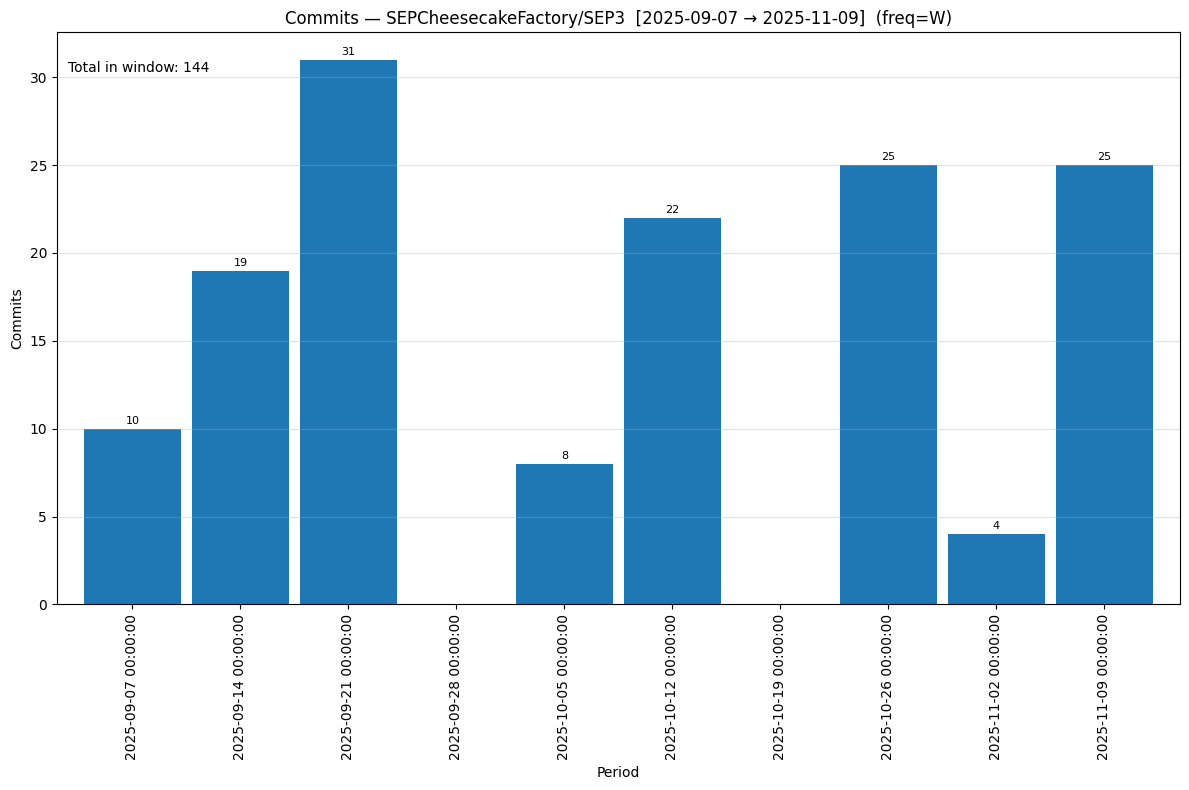

In [44]:
window_total = commit_total_in_window(df, date_from, date_to)
print("\n=== Commits (selected window) ===")
print("Total:", window_total)

plot_commits_configurable(
    df=df,
    repo_full_name=repo_info.get("full_name", f"{owner}/{repo}"),
    date_from=date_from,
    date_to=date_to,
    freq=freq,
    chart=chart,
    rolling=rolling,
    show_values=show_values,
    chartfigsize=(12,8)
)